Global spatial autocorrelation analysis for 2024 presidential election in Virginia

In [69]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

import matplotlib.colors as mcolors

In [91]:
va_vote_data_path = "./2024_VA_County_Level_Presidential_Results.csv"
#va_vote_df = pandas.read_csv(va_vote_data_path, index_col="county_fips")

va_vote_df = pandas.read_csv(va_vote_data_path)


In [95]:
va_vote_df['county_fips'] = va_vote_df['county_fips'].astype("string")

In [96]:
va_vote_df['per_gop'] = va_vote_df['per_gop']*100
va_vote_df['per_dem'] = va_vote_df['per_dem']*100
va_vote_df['per_point_diff'] = va_vote_df['per_point_diff']*100

In [98]:
VA_Counties_gdf = geopandas.read_file(
    "./VA_Counties.json"
)

In [99]:
VA_Counties_gdf= VA_Counties_gdf[["US_Counties_20m_GEOID","geometry"]]

In [100]:
db = VA_Counties_gdf.merge(va_vote_df, left_on="US_Counties_20m_GEOID", right_on="county_fips", how="left")


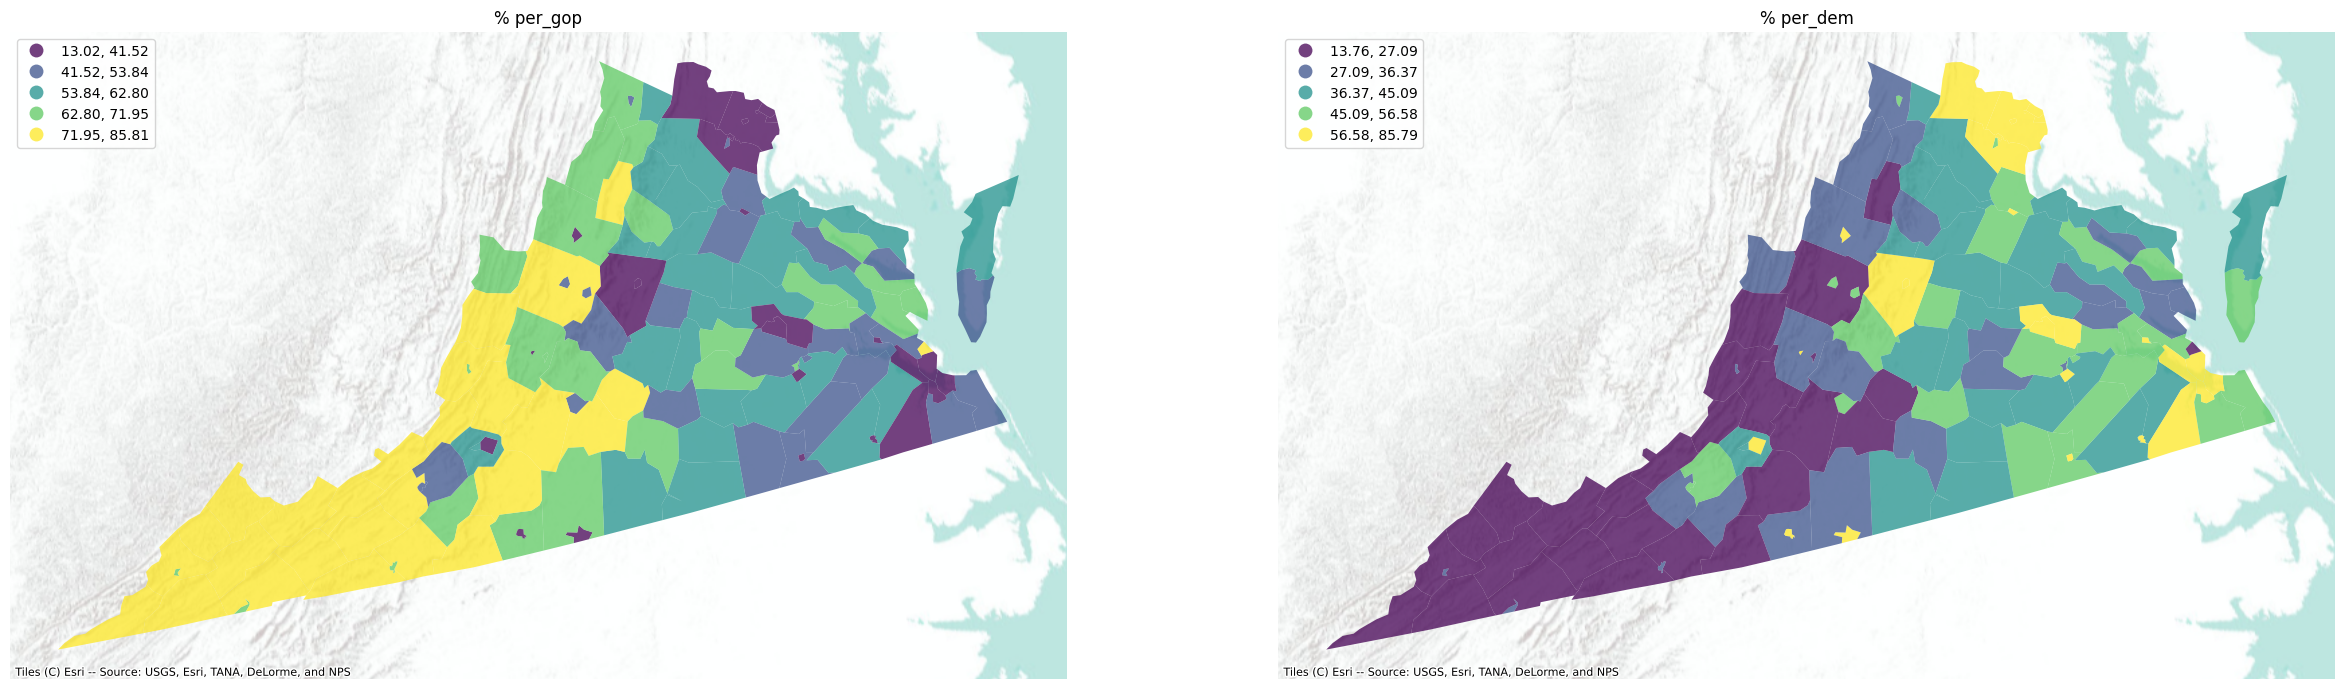

In [101]:
f, axs = plt.subplots(1, 2,figsize=(30, 15))
ax1, ax2 = axs
db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax1,
)
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax1.set_title("% per_gop")
ax1.set_axis_off()

db.plot(
    column="per_dem",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax2,
)
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax2.set_title("% per_dem")
ax2.set_axis_off()

In [102]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

In [103]:
db["per_gop_lag"] = weights.spatial_lag.lag_spatial(
    w, db["per_gop"]
)

In [104]:
db["per_dem_lag"] = weights.spatial_lag.lag_spatial(
    w, db["per_dem"]
)

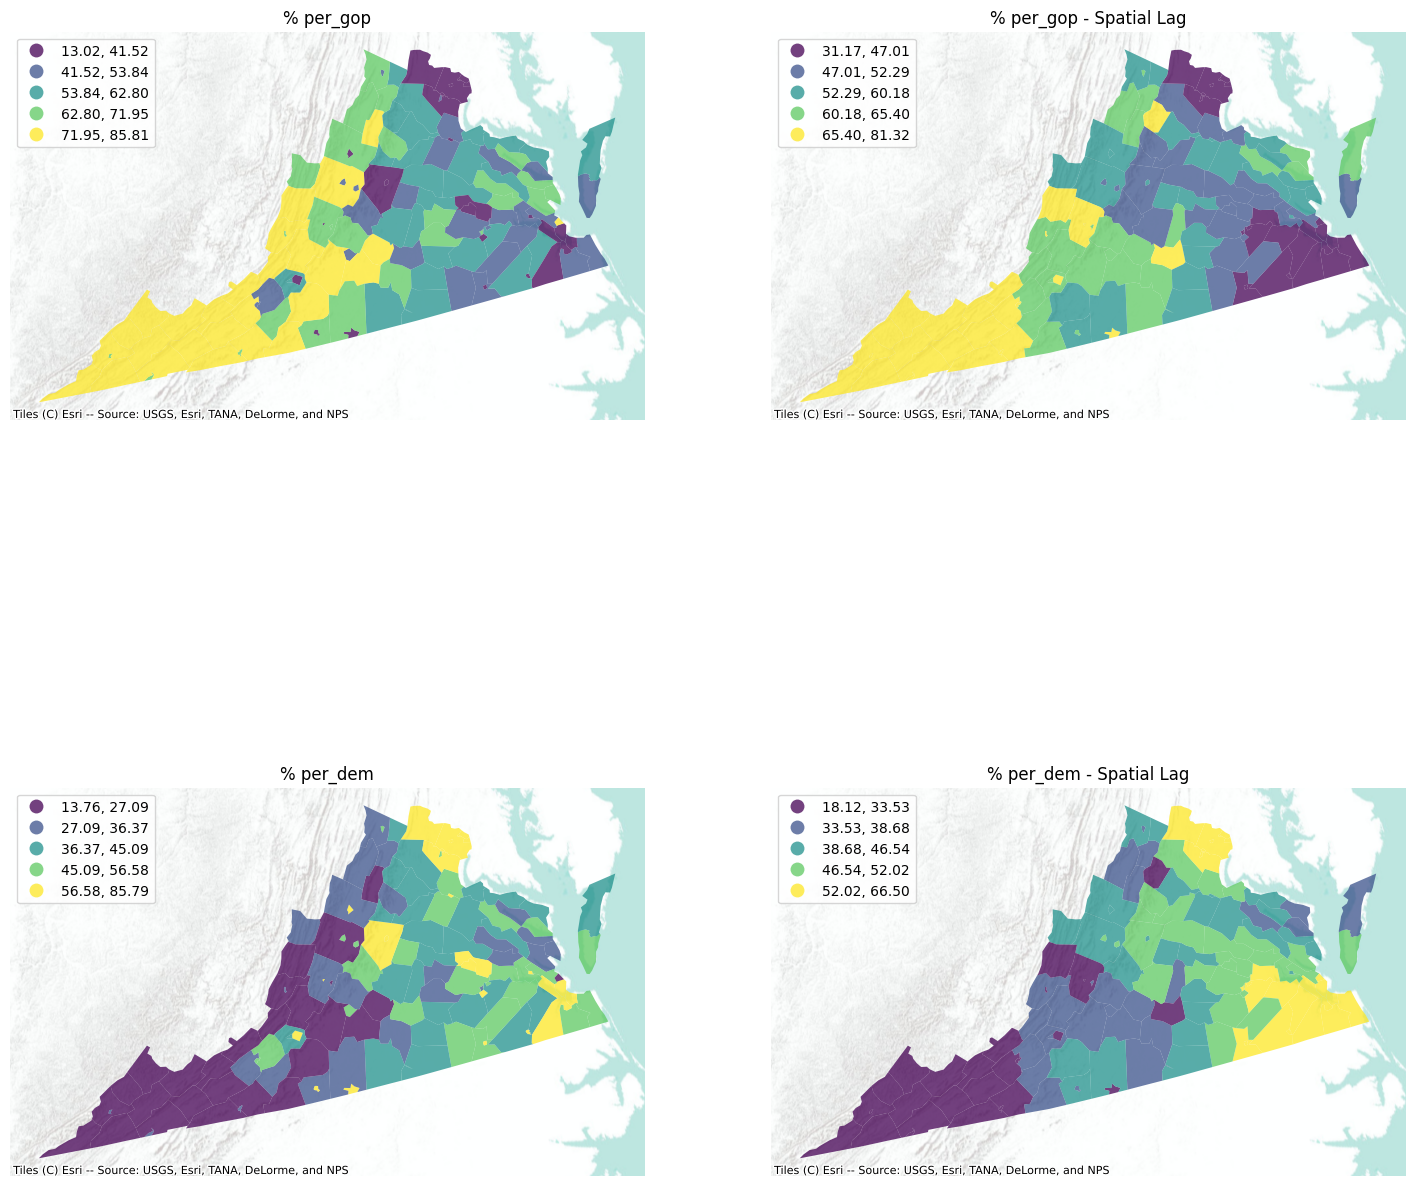

In [105]:
f, axs = plt.subplots(2, 2, figsize=(18, 18))
ax1, ax2, ax3, ax4 = axs.flatten()

db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% per_gop")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_gop_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% per_gop - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_dem",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax3,
)
ax3.set_axis_off()
ax3.set_title("% per_dem")
contextily.add_basemap(
    ax3,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_dem_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax4,
)
ax4.set_axis_off()
ax4.set_title("% per_dem - Spatial Lag")
contextily.add_basemap(
    ax4,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)


plt.show()

In [106]:
db["win_gop"] = (db["per_gop"] > db["per_dem"] ).astype(int)
db[["per_gop", "win_gop"]].tail()

,per_gop,win_gop
128,67.995718,1
129,48.809160,0
130,60.184133,1
131,38.087664,0
132,46.323587,0


In [107]:
db["win_dem"] = (db["per_dem"] > db["per_gop"] ).astype(int)
db[["per_dem", "win_dem"]].tail()

,per_dem,win_dem
128,30.948313,0
129,49.328244,1
130,38.883837,0
131,60.710498,1
132,52.546569,1


In [108]:
db["win"] = db["win_gop"].apply(lambda x: "gop" if x == 1 else "dem")

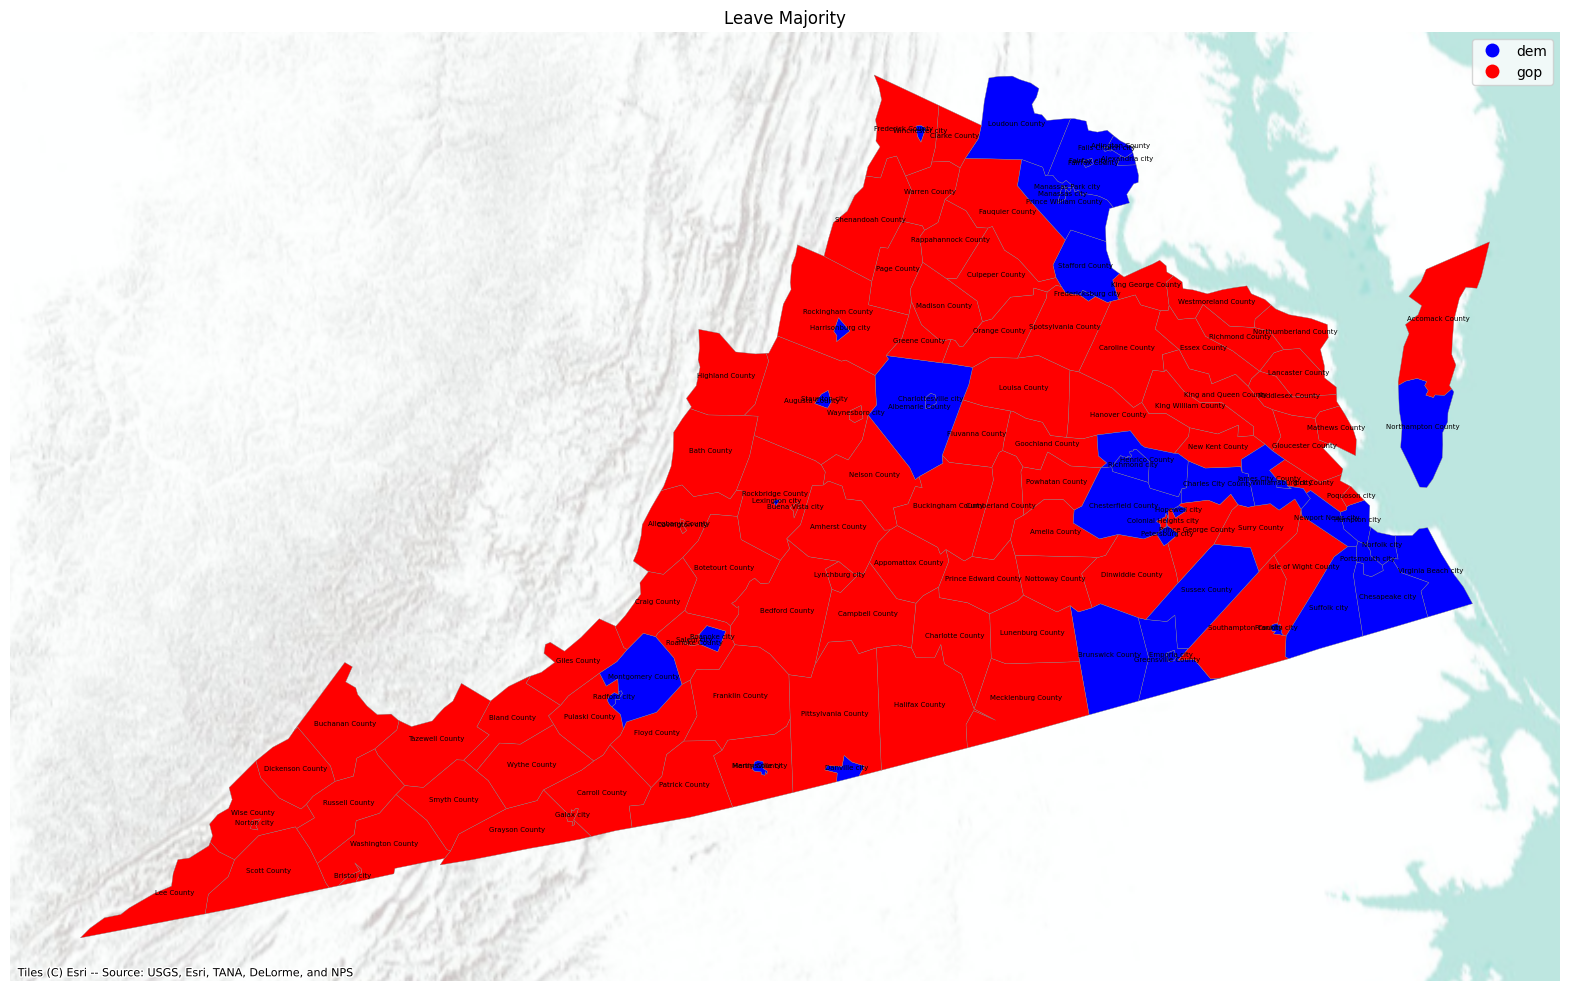

In [109]:
cmap_gop = mcolors.ListedColormap(["blue", "red"])  # Blue for 0, Red for 1
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap_gop.N)
f, ax = plt.subplots(1, figsize=(20, 20))
db.plot(
    ax=ax,
    column="win",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap=cmap_gop,  # Use custom colormap
    norm=norm,
)
ax.set_axis_off()
ax.set_title("Leave Majority")
#plt.axis("equal")
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

# Label counties with 'win_gop' value of 1
for idx, row in db.iterrows():  # Filter rows where 'win_gop' == 1
    centroid = row.geometry.centroid
    county_name = row['county_name']  # Assuming county names are in a column named 'county_name'
    ax.text(centroid.x, centroid.y, county_name, fontsize=5, ha='center', color='black')
plt.show()

In [110]:
w.transform

'R'

In [111]:
w.transform = "O"

In [112]:
w.transform

'O'

In [113]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["win_gop"], w)
jc

In [27]:
jc.bb

277.5

In [28]:
jc.ww

93.5

In [29]:
jc.bw

161.0

In [30]:
jc.bb + jc.ww + jc.bw

532.0

In [31]:
jc.J

532.0

In [32]:
jc.mean_bb

242.56206206206207

In [33]:
jc.mean_bw

234.84034034034033

In [34]:
jc.p_sim_bb

0.001

In [35]:
jc.p_sim_bw

1.0

In [65]:
db["per_gop_std"] = db["per_gop"] - db["per_gop"].mean()
db["per_gop_lag_std"] = weights.lag_spatial(
    w, db["per_gop_std"]
)

In [66]:
db["per_dem_std"] = db["per_dem"] - db["per_dem"].mean()
db["per_dem_lag_std"] = weights.lag_spatial(
    w, db["per_dem_std"]
)

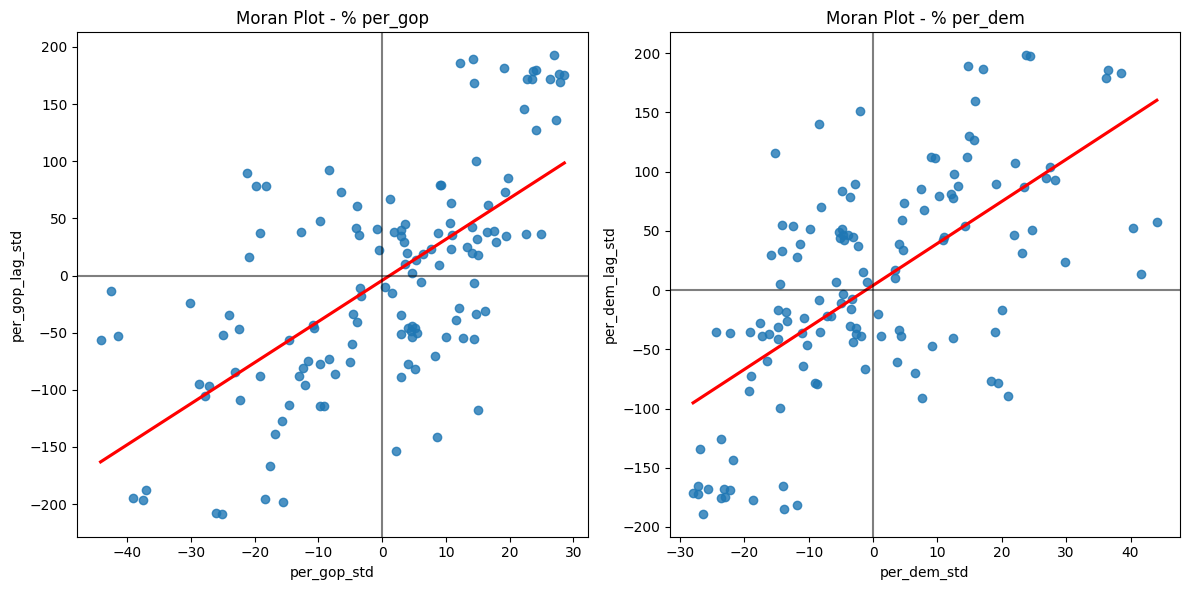

In [74]:


# Create a figure with 2 subplots (side by side)
f, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot 1 (Moran Plot - % per_gop)
seaborn.regplot(
    x="per_gop_std",
    y="per_gop_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
    ax=axs[0],  # Assign the first subplot
)
axs[0].axvline(0, c="k", alpha=0.5)
axs[0].axhline(0, c="k", alpha=0.5)
axs[0].set_title("Moran Plot - % per_gop")

# Plot 2 (Moran Plot - % per_dem)
seaborn.regplot(
    x="per_dem_std",
    y="per_dem_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
    ax=axs[1],  # Assign the second subplot
)
axs[1].axvline(0, c="k", alpha=0.5)
axs[1].axhline(0, c="k", alpha=0.5)
axs[1].set_title("Moran Plot - % per_dem")

# Show the combined figure
plt.tight_layout()  # To adjust spacing between subplots
plt.show()


In [76]:
w.transform = "R"
moran_gop = esda.moran.Moran(db["per_gop"], w)

In [77]:
w.transform = "R"
moran_dem = esda.moran.Moran(db["per_dem"], w)

In [78]:
moran_gop.I

0.44916720841726904

In [79]:
moran_dem.I

0.4432868814954128

In [80]:
moran_gop.p_sim

0.001

In [81]:
moran_dem.p_sim

0.001

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


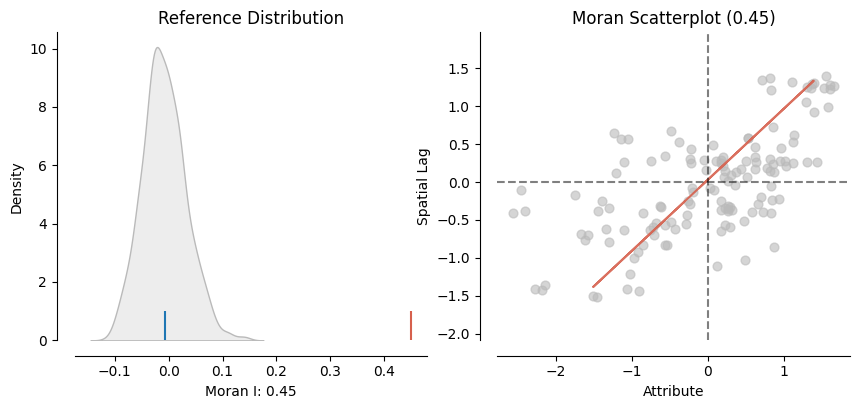

In [82]:
plot_moran(moran_gop);

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


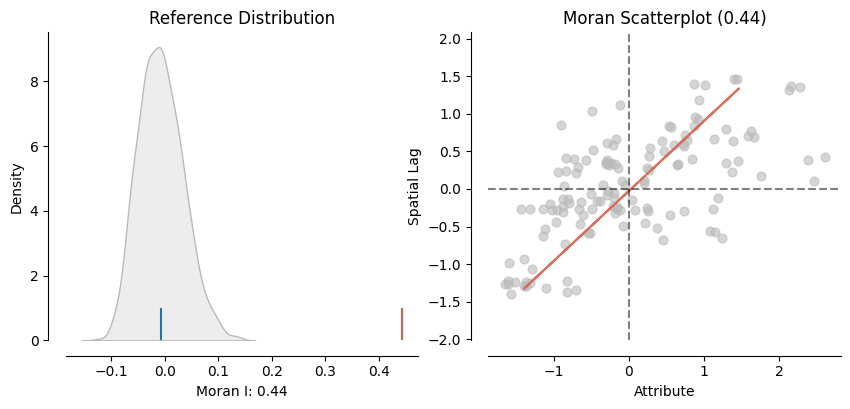

In [190]:
plot_moran(moran_dem);